#Data Preparation

In [ ]:
!nvidia-smi

Thu Nov 23 13:21:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    46W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip gdrive/My\ Drive/DataScienceProjects/WireSegInpaint/WiresegLR_410.zip > /dev/null

In [ ]:
!pip install patchify

In [ ]:
!pip install -U -q segmentation-models

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 3.6 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [ ]:
import os
import gc
import cv2
import numpy as np

from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
#import segmentation_models as sm ##Throws error
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

root_directory = 'WiresegLR_410/'

patch_size = 1024 #Patch size for training

In [ ]:
for path, subdirs, files in sorted(os.walk(root_directory)):
    print(path)

WiresegLR_410/
WiresegLR_410/gts
WiresegLR_410/images


In [ ]:
Wireimage_dataset = []
for path, subdirs, files in sorted(os.walk(root_directory)): #sorted() will solve the colob problem
    #print(path)
    directoryname = path.split(os.path.sep)[-1]
    if directoryname == 'images':
        images = os.listdir(path)
        for i, image_name in enumerate(sorted(images)):
            if image_name.endswith(".jpg"):

                image = cv2.imread(path+"/"+image_name, 1)
                SIZE_OF_X = (image.shape[1]//patch_size)*patch_size
                SIZE_OF_Y = (image.shape[0]//patch_size)*patch_size
                image = Image.fromarray(image)
                image = image.crop((0 ,0, SIZE_OF_X, SIZE_OF_Y))
                image = np.array(image)
                print("Now patchifying image:", path+"/"+image_name)
                patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

                for i in range(patches_img.shape[0]):
                    for j in range(patches_img.shape[1]):
                        single_patch_img = patches_img[i,j,:,:]
                        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
                        single_patch_img = single_patch_img[0]
                        Wireimage_dataset.append(single_patch_img)
                        gc.collect()

Now patchifying image: WiresegLR_410/images/1.jpg
Now patchifying image: WiresegLR_410/images/10.jpg
Now patchifying image: WiresegLR_410/images/100.jpg
Now patchifying image: WiresegLR_410/images/101.jpg
Now patchifying image: WiresegLR_410/images/102.jpg
Now patchifying image: WiresegLR_410/images/103.jpg
Now patchifying image: WiresegLR_410/images/104.jpg
Now patchifying image: WiresegLR_410/images/105.jpg
Now patchifying image: WiresegLR_410/images/106.jpg
Now patchifying image: WiresegLR_410/images/107.jpg
Now patchifying image: WiresegLR_410/images/108.jpg
Now patchifying image: WiresegLR_410/images/109.jpg
Now patchifying image: WiresegLR_410/images/11.jpg
Now patchifying image: WiresegLR_410/images/110.jpg
Now patchifying image: WiresegLR_410/images/111.jpg
Now patchifying image: WiresegLR_410/images/112.jpg
Now patchifying image: WiresegLR_410/images/113.jpg
Now patchifying image: WiresegLR_410/images/114.jpg
Now patchifying image: WiresegLR_410/images/115.jpg
Now patchifying 

In [ ]:
#!pip install joblib

In [ ]:
#import joblib
#from google.colab import files

In [ ]:
#joblib.dump(Wireimage_dataset,  'Wireimage_dataset.pkl')

['image_dataset.pkl']

In [ ]:
#files.download('Wireimage_dataset.pkl') #Download into local

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
gc.collect()

0

In [ ]:
mask_dataset = []
for path, subdirs, files in sorted(os.walk(root_directory)):
    #print(path)
    directoryname = path.split(os.path.sep)[-1]
    if directoryname == 'gts':
        masks = os.listdir(path)
        for i, mask_name in enumerate(sorted(masks)):
            if mask_name.endswith(".png"):

                mask = cv2.imread(path+"/"+mask_name, 1)
                mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
                SIZE_OF_X = (mask.shape[1]//patch_size)*patch_size
                SIZE_OF_Y = (mask.shape[0]//patch_size)*patch_size
                mask = Image.fromarray(mask)
                mask = mask.crop((0 ,0, SIZE_OF_X, SIZE_OF_Y))
                mask = np.array(mask)

                print("Now patchifying mask:", path+"/"+mask_name)
                patches_mask = patchify(mask, (patch_size, patch_size, 3), step=patch_size)

                for i in range(patches_mask.shape[0]):
                    for j in range(patches_mask.shape[1]):

                        single_patch_mask = patches_mask[i,j,:,:]
                        single_patch_mask = single_patch_mask[0]
                        mask_dataset.append(single_patch_mask)


Now patchifying mask: WiresegLR_410/gts/1.png
Now patchifying mask: WiresegLR_410/gts/10.png
Now patchifying mask: WiresegLR_410/gts/100.png
Now patchifying mask: WiresegLR_410/gts/101.png
Now patchifying mask: WiresegLR_410/gts/102.png
Now patchifying mask: WiresegLR_410/gts/103.png
Now patchifying mask: WiresegLR_410/gts/104.png
Now patchifying mask: WiresegLR_410/gts/105.png
Now patchifying mask: WiresegLR_410/gts/106.png
Now patchifying mask: WiresegLR_410/gts/107.png
Now patchifying mask: WiresegLR_410/gts/108.png
Now patchifying mask: WiresegLR_410/gts/109.png
Now patchifying mask: WiresegLR_410/gts/11.png
Now patchifying mask: WiresegLR_410/gts/110.png
Now patchifying mask: WiresegLR_410/gts/111.png
Now patchifying mask: WiresegLR_410/gts/112.png
Now patchifying mask: WiresegLR_410/gts/113.png
Now patchifying mask: WiresegLR_410/gts/114.png
Now patchifying mask: WiresegLR_410/gts/115.png
Now patchifying mask: WiresegLR_410/gts/116.png
Now patchifying mask: WiresegLR_410/gts/117.

In [ ]:
#load the Dataset as Numpy array
Wireimage_dataset = np.array(Wireimage_dataset)
mask_dataset =  np.array(mask_dataset)

199


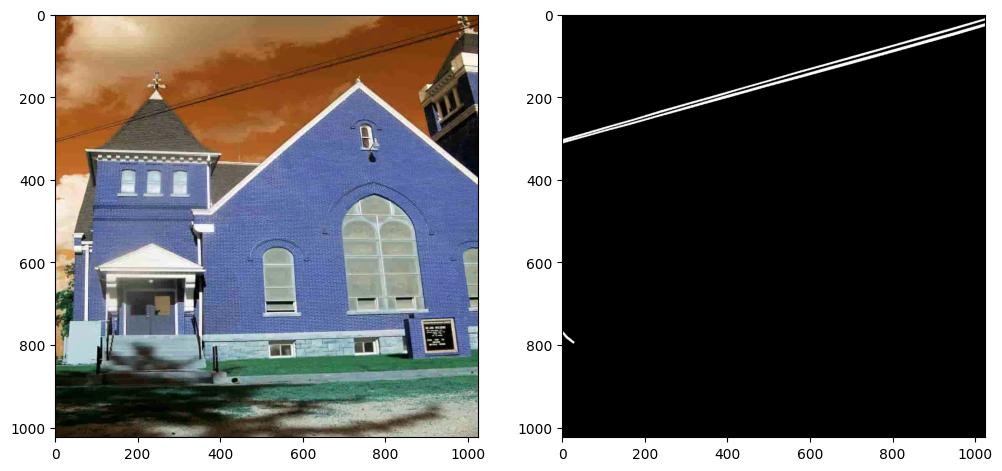

In [ ]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(Wireimage_dataset))
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(Wireimage_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [ ]:
import numpy as np

# Save a NumPy array
np.save('Wireimage_dataset.npy', Wireimage_dataset)
np.save('mask_dataset.npy', mask_dataset)
np.save('single_patch_img.npy', single_patch_img)
np.save('single_patch_mask.npy', single_patch_mask)
# Load a NumPy array
#loaded_array = np.load('array.npy')


In [ ]:
#import os ##resrarting the run time
#os.kill(os.getpid(), 9)

In [ ]:
#Wireimage_dataset = joblib.load('Wireimage_dataset_1.pkl')

In [ ]:
#Wireimage_dataset.shape
#!file Wireimage_dataset_1.pkl

image_dataset_1.pkl: data


#Preprocessing

In [ ]:
#!cat Wireimage_dataset_1.pkl | python -m cPickle.dump -

/usr/bin/python3: Error while finding module specification for 'cPickle.dump' (ModuleNotFoundError: No module named 'cPickle')


In [ ]:
#single_patch_mask =  np.load('single_patch_mask.npy')

In [ ]:
#a=int('FF', 16)  #FF with base 16. Should return 255.
#print(a)

255


In [ ]:
Wire = '#FFFFFF'.lstrip('#')
Wire = np.array(tuple(int(Wire[i:i+2], 16) for i in (0, 2, 4))) # 255, 255, 255 white

Unlabeled = '#000000'.lstrip('#')
Unlabeled = np.array(tuple(int(Unlabeled[i:i+2], 16) for i in (0, 2, 4))) #0, 0, 0 black

label = single_patch_mask

In [ ]:
mask_dataset[1]

array([[[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]],

       ...,

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]]], dtype=uint8)

In [ ]:
#Wireimage_dataset = np.array(Wireimage_dataset)
#mask_dataset =  np.array(mask_dataset)

In [ ]:
def rgb_to_2D_label(label):
    """
    Suply our labale masks as input in RGB format.
    Replace pixels with specific RGB values ...
    """
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    label_seg [np.all(label == Wire,axis=-1)] = 0
    label_seg [np.all(label == Unlabeled,axis=-1)] = 1

    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels

    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    print("Before",i,np.unique(mask_dataset[i]))
    my_mask = np.where(mask_dataset[i]>50, 0, 1)
    print("Before",i,np.unique(my_mask))
    label = rgb_to_2D_label(my_mask)
    print("After",i,np.unique(np.array(label)))
    labels.append(label)

labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)


print("Unique labels in label dataset are: ", np.unique(labels))

Before 0 [  1  83 147 205 254]
Before 0 [0 1]
After 0 [0 1]
Before 1 [  4  71 131 189 251]
Before 1 [0 1]
After 1 [0 1]
Before 2 [  3  70 130 191 252]
Before 2 [0 1]
After 2 [0 1]
Before 3 [  0  84 150 206 253]
Before 3 [0 1]
After 3 [0 1]
Before 4 [  1  67 127 191 253]
Before 4 [0 1]
After 4 [0 1]
Before 5 [  1  88 170 248]
Before 5 [0 1]
After 5 [0 1]
Before 6 [  4  72 130 190 251]
Before 6 [0 1]
After 6 [0 1]
Before 7 [  1  57 108 160 210 253]
Before 7 [0 1]
After 7 [0 1]
Before 8 [  2  65 130 193 252]
Before 8 [0 1]
After 8 [0 1]
Before 9 [  1 141 250]
Before 9 [0 1]
After 9 [0 1]
Before 10 [  0  83 147 204 253]
Before 10 [0 1]
After 10 [0 1]
Before 11 [  1  95 179 250]
Before 11 [0 1]
After 11 [0 1]
Before 12 [  3  71 131 193 251]
Before 12 [0 1]
After 12 [0 1]
Before 13 [  3  98 179 251]
Before 13 [0 1]
After 13 [0 1]
Before 14 [  0 146 249]
Before 14 [0 1]
After 14 [0 1]
Before 15 [  0  81 147 202 252]
Before 15 [0 1]
After 15 [0 1]
Before 16 [  2 101 184 250]
Before 16 [0 1]
Af

108


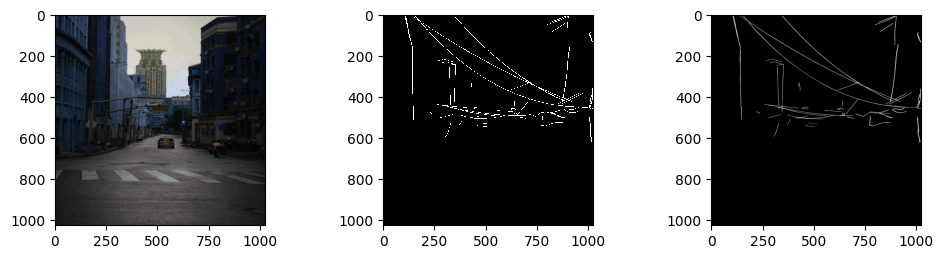

In [ ]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(Wireimage_dataset))
#image_number = 1
print(image_number)
plt.figure(figsize=(12, 6))
plt.subplot(231)
plt.imshow(Wireimage_dataset[image_number-1])
plt.subplot(232)
plt.imshow(labels[image_number-1][:,:,0],cmap='Greys_r',  interpolation='nearest')
plt.subplot(233)#
plt.imshow(mask_dataset[image_number-1])
plt.show()

In [ ]:
print(Wireimage_dataset.shape)
print(mask_dataset.shape)

(426, 1024, 1024, 3)
(426, 1024, 1024, 3)


#U-Net Model

In [ ]:
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Wireimage_dataset, labels_cat, test_size = 0.20, random_state = 42)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(340, 1024, 1024, 3)
(340, 1024, 1024, 2)
(86, 1024, 1024, 3)
(86, 1024, 1024, 2)


In [ ]:
import numpy as np

# Save a NumPy array
np.save('labels.npy', labels)
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)
# Load a NumPy array
#loaded_array = np.load('array.npy')


In [ ]:
weights = [0.5, 0.5]
dice_loss = sm.losses.DiceLoss(class_weights=weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  #

IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]


In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K

def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def multi_unet_model(n_classes=4, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)  # Original 0.1
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)  # Original 0.1
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)  # Original 0.1
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)  # Original 0.1
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

    return model


In [ ]:
metrics=['accuracy', jacard_coef]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1024, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 1024, 1024, 16)       448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 1024, 1024, 16)       0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 1024, 1024, 16)       2320      ['dropout[0][0]']             
                                                                                              

In [ ]:
model.input_shape

(None, 1024, 1024, 3)

##Training the Model

In [ ]:
history1 = model.fit(X_train, y_train,
                    batch_size = 16,
                    verbose=1,
                    epochs=100,
                    validation_data=(X_test, y_test),
                    shuffle=False)

Epoch 1/100
22/22 [==============================] - 108s 1s/step - loss: 0.7721 - accuracy: 0.9712 - jacard_coef: 0.8162 - val_loss: 0.7631 - val_accuracy: 0.9867 - val_jacard_coef: 0.8325
Epoch 2/100
22/22 [==============================] - 10s 478ms/step - loss: 0.7619 - accuracy: 0.9820 - jacard_coef: 0.8794 - val_loss: 0.7602 - val_accuracy: 0.9867 - val_jacard_coef: 0.8430
Epoch 3/100
22/22 [==============================] - 11s 480ms/step - loss: 0.7587 - accuracy: 0.9820 - jacard_coef: 0.8890 - val_loss: 0.7571 - val_accuracy: 0.9867 - val_jacard_coef: 0.8855
Epoch 4/100
22/22 [==============================] - 11s 480ms/step - loss: 0.7570 - accuracy: 0.9820 - jacard_coef: 0.8857 - val_loss: 0.7580 - val_accuracy: 0.9867 - val_jacard_coef: 0.8540
Epoch 5/100
22/22 [==============================] - 11s 480ms/step - loss: 0.7571 - accuracy: 0.9820 - jacard_coef: 0.8966 - val_loss: 0.7553 - val_accuracy: 0.9867 - val_jacard_coef: 0.9286
Epoch 6/100
22/22 [=======================

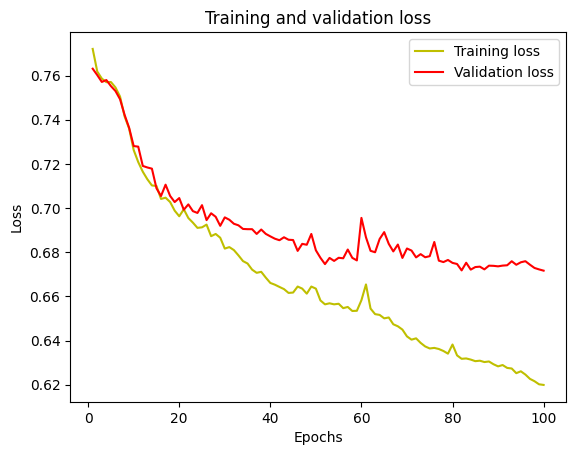

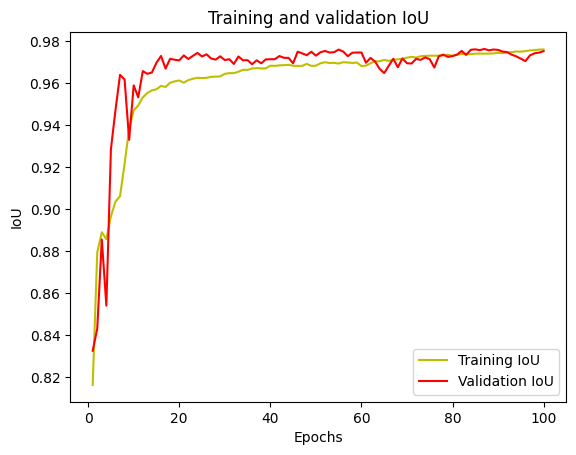

In [ ]:
#plot the training and validation accuracy and loss at each epoch
history = history1
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

In [ ]:
#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

3/3 [==============================] - 1s 236ms/step
Mean IoU = 0.58773977


#Evaluation

65
1/1 [==============================] - 0s 28ms/step


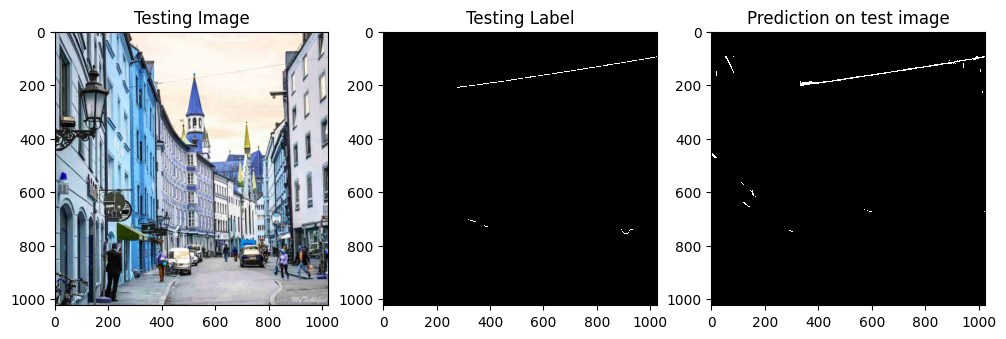

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
print(test_img_number)
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth,cmap='Greys_r',  interpolation='nearest')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img,cmap='Greys_r',  interpolation='nearest')
plt.show()

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
for i in range(len(X_test)):
    test_img_number = i
    print(test_img_number)
    test_img = X_test[test_img_number]
    ground_truth=y_test_argmax[test_img_number]
    #test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth,cmap='Greys_r',  interpolation='nearest')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img,cmap='Greys_r',  interpolation='nearest')
    plt.show()

29
1/1 [==============================] - 0s 31ms/step


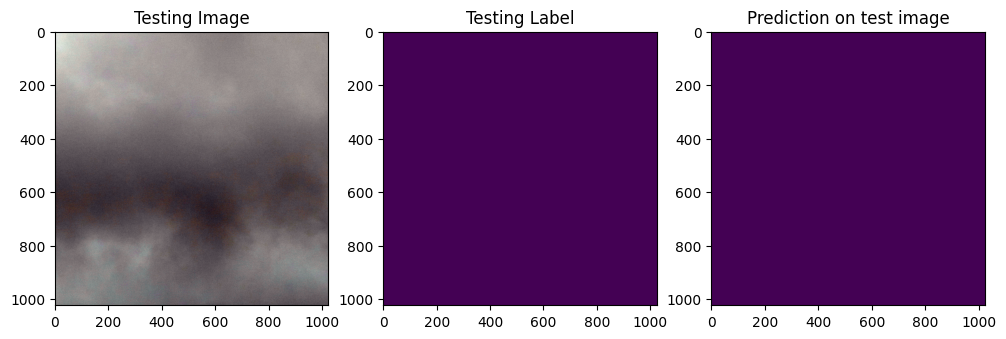

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
print(test_img_number)
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

In [ ]:
y_pred=model.predict(X_train)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_train_argmax=np.argmax(y_train, axis=3)

11/11 [==============================] - 8s 730ms/step


In [ ]:
#Predict on a all images

import random
test_img_number = random.randint(0, len(X_train))
for i in range(len(X_train)):
    test_img_number = i
    print(test_img_number)
    test_img = X_train[test_img_number]
    ground_truth=y_train_argmax[test_img_number]
    #test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img)
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth,cmap='Greys_r',  interpolation='nearest')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img,cmap='Greys_r',  interpolation='nearest')
    plt.show()